In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to/
    train=True,# do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=transform, # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.8MB/s]


In [6]:
class_names = train_data.classes

In [7]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f59accdacc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f59ace7d9d0>)

In [8]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  model = model.to(device)
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # Make predictions
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, #only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}


In [9]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler.StepLR,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0,0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X_train, y_train) in enumerate(data_loader):
    # Put data on target device
    X_train, y_train = X_train.to(device), y_train.to(device)

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y_train,
                             y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Divide total train loss by length of train dataloader
  scheduler.step()
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
  return train_acc

In [10]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0,0
  # Put model into training mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")
    return test_acc

In [11]:
# Create a convolutional neural network
class FashionMNISTModel(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units), # Values we can set ourselves in our NN's are called hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout2d(0.3),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout2d(0.3),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.3),
        nn.Linear(in_features=hidden_units*9, 
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_2(self.conv_block_1(x))))

In [12]:
model = FashionMNISTModel(input_shape=1,
                              hidden_units=128,
                              output_shape=len(class_names)).to(device)

In [13]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.5
)


In [15]:
epochs = 10
start = timer()
best_acc = 0
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_acc = train_step(
      model=model,
      data_loader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      scheduler=scheduler,
      accuracy_fn=accuracy_fn,
      device=device
  )
  test_acc = test_step(
      model=model,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      device=device
  )
  if(test_acc>best_acc):
    best_acc = test_acc
    torch.save(model.state_dict(), "best_model.pth")
end = timer()
print(f"Train time on {device}: {end - start}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.55552 | Train acc: 79.73%
Test loss: 0.37375 | Test acc: 86.57%

Epoch: 1
-------
Train loss: 0.38349 | Train acc: 86.06%
Test loss: 0.33332 | Test acc: 87.91%

Epoch: 2
-------
Train loss: 0.33847 | Train acc: 87.75%
Test loss: 0.31240 | Test acc: 88.52%

Epoch: 3
-------
Train loss: 0.31464 | Train acc: 88.77%
Test loss: 0.29331 | Test acc: 89.45%

Epoch: 4
-------
Train loss: 0.29991 | Train acc: 89.17%
Test loss: 0.31529 | Test acc: 88.76%

Epoch: 5
-------
Train loss: 0.26399 | Train acc: 90.40%
Test loss: 0.26373 | Test acc: 90.27%

Epoch: 6
-------
Train loss: 0.25217 | Train acc: 90.86%
Test loss: 0.28603 | Test acc: 89.54%

Epoch: 7
-------
Train loss: 0.24547 | Train acc: 91.13%
Test loss: 0.25297 | Test acc: 90.91%

Epoch: 8
-------
Train loss: 0.24009 | Train acc: 91.20%
Test loss: 0.25693 | Test acc: 90.97%

Epoch: 9
-------
Train loss: 0.23518 | Train acc: 91.51%
Test loss: 0.24412 | Test acc: 91.38%

Train time on cuda: 355.861701006


In [19]:
num_classes = len(class_names)
conf_matrix = torch.zeros(num_classes, num_classes)

model.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        preds = torch.argmax(logits, dim=1)

        for t, p in zip(y.view(-1), preds.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

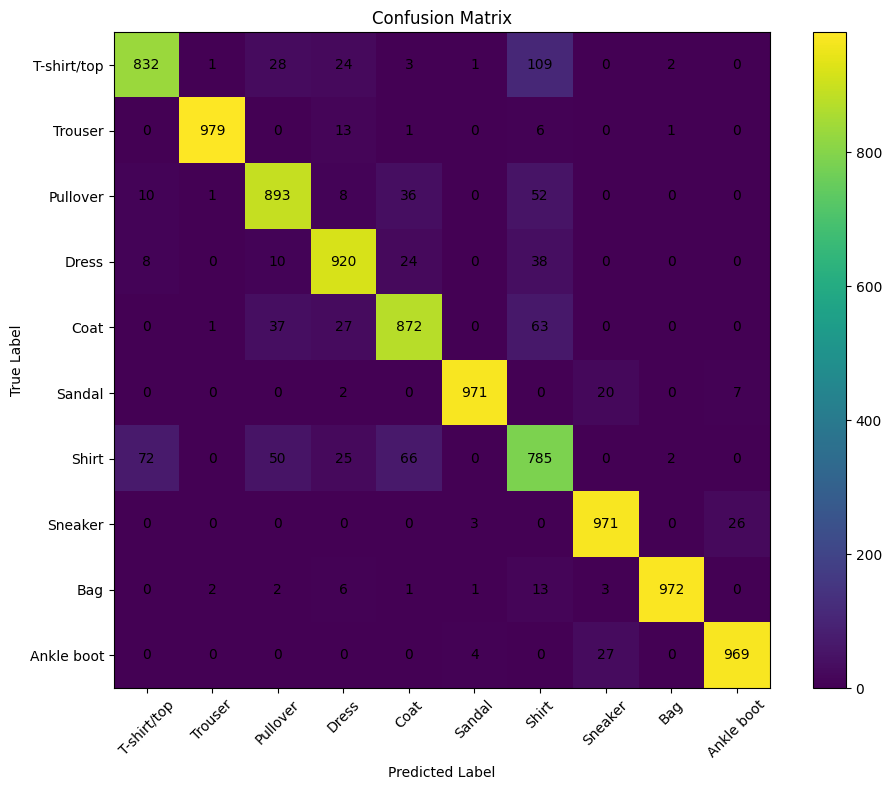

In [20]:
import matplotlib.pyplot as plt

cm = conf_matrix.cpu().numpy()

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = range(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add numbers inside boxes
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, int(cm[i, j]),
                 ha="center", va="center")

plt.tight_layout()
plt.show()

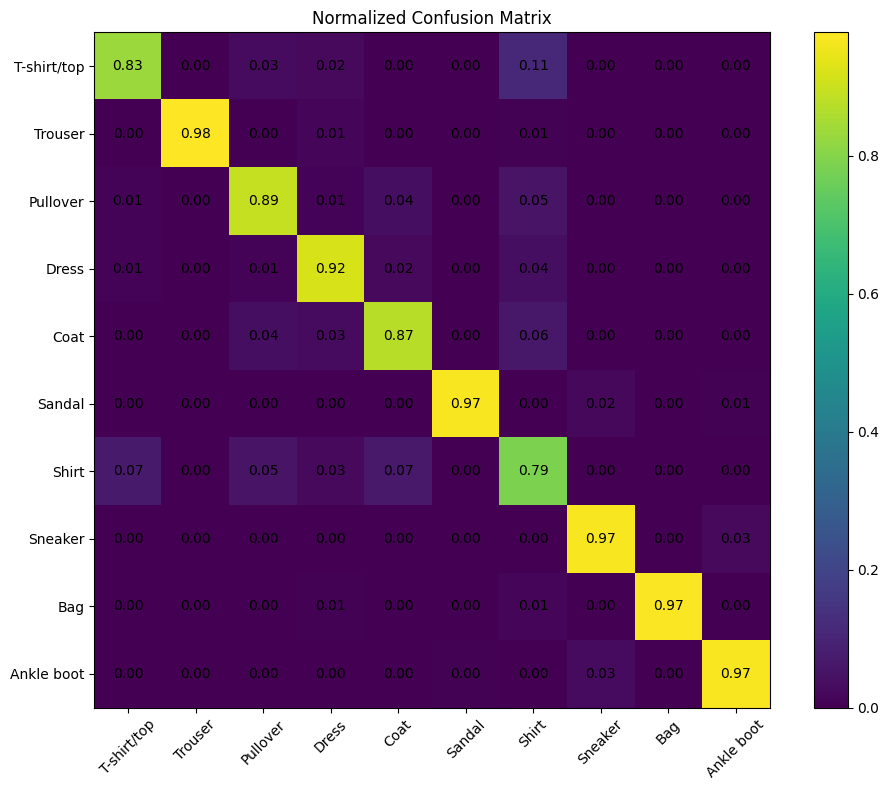

In [21]:
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
plt.imshow(cm_norm)
plt.title("Normalized Confusion Matrix")
plt.colorbar()

plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center", va="center")

plt.tight_layout()
plt.show()

In [27]:

per_class_acc = cm.diagonal() / cm.sum(axis=1)

In [28]:
per_class_acc

array([0.832, 0.979, 0.893, 0.92 , 0.872, 0.971, 0.785, 0.971, 0.972,
       0.969], dtype=float32)